# <p style="padding:15px; background-color:#362FD9; font-family:JetBrains Mono; font-weight:bold; color:#000000; font-size:100%; letter-spacing: 2px; text-align:center; border-radius: 15px 15px; border: 5px solid #000000">Deep learning based Network Slicing Classification</p>

# <p style="padding:15px; background-color:#525FE1; font-family:JetBrains Mono; font-weight:bold; color:#000000; font-size:100%; letter-spacing: 2px; text-align:center; border-radius: 15px 15px; border: 5px solid #000000"> I. Libraries && Data</p>

In [1]:
!pip install iterative-stratification

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing
from pandas.api.types import is_numeric_dtype
import seaborn as sns
sns.set_palette("bright")
import matplotlib.pyplot as plt

import optuna
from optuna.samplers import TPESampler

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold,train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# Models
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold, RepeatedMultilabelStratifiedKFold
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier


# Ignore warnings ;)
import warnings
warnings.simplefilter("ignore")

In [3]:
# files path
train_path     = "/kaggle/input/network-slicing-in-5g/train_dataset.csv"
test_path      = "/kaggle/input/network-slicing-in-5g/test_dataset.csv"

# function to import our dataset 
def import_data(train_path, test_path):     
    train      =  pd.read_csv(train_path)
    test       =  pd.read_csv(test_path)
    
    return train, test

train, test = import_data(train_path, test_path)

# <p style="padding:15px; background-color:#362FD9; font-family:JetBrains Mono; font-weight:bold; color:#000000; font-size:100%; letter-spacing: 2px; text-align:center; border-radius: 15px 15px; border: 5px solid #000000">II. Exploratory Data Analysis - EDA</p> 

In [4]:
train.head(5)

,LTE/5g Category,Time,Packet Loss Rate,Packet delay,IoT,LTE/5G,GBR,Non-GBR,AR/VR/Gaming,Healthcare,Industry 4.0,IoT Devices,Public Safety,Smart City & Home,Smart Transportation,Smartphone,slice Type
0,14,0,0.000001,10,1,0,0,1,0,0,0,0,1,0,0,0,3
1,18,20,0.001000,100,0,1,1,0,1,0,0,0,0,0,0,0,1
2,17,14,0.000001,300,0,1,0,1,0,0,0,0,0,0,0,1,1
3,3,17,0.010000,100,0,1,0,1,0,0,0,0,0,0,0,1,1
4,9,4,0.010000,50,1,0,0,1,0,0,0,0,0,1,0,0,2


In [5]:
test.head(5)

,LTE/5g Category,Time,Packet Loss Rate,Packet delay,IoT,LTE/5G,GBR,Non-GBR,AR/VR/Gaming,Healthcare,Industry 4.0,IoT Devices,Public Safety,Smart City & Home,Smart Transportation,Smartphone
0,15,17,0.001000,100,0,1,1,0,1,0,0,0,0,0,0,0
1,14,18,0.000001,10,1,0,0,1,0,0,0,0,0,0,1,0
2,11,7,0.001000,50,1,0,1,0,0,0,1,0,0,0,0,0
3,20,14,0.001000,50,1,0,1,0,0,0,1,0,0,0,0,0
4,2,22,0.001000,50,0,1,0,1,1,0,0,0,0,0,0,0


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31583 entries, 0 to 31582
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   LTE/5g Category       31583 non-null  int64  
 1   Time                  31583 non-null  int64  
 2   Packet Loss Rate      31583 non-null  float64
 3   Packet delay          31583 non-null  int64  
 4   IoT                   31583 non-null  int64  
 5   LTE/5G                31583 non-null  int64  
 6   GBR                   31583 non-null  int64  
 7   Non-GBR               31583 non-null  int64  
 8   AR/VR/Gaming          31583 non-null  int64  
 9   Healthcare            31583 non-null  int64  
 10  Industry 4.0          31583 non-null  int64  
 11  IoT Devices           31583 non-null  int64  
 12  Public Safety         31583 non-null  int64  
 13  Smart City & Home     31583 non-null  int64  
 14  Smart Transportation  31583 non-null  int64  
 15  Smartphone         

<p style="padding:15px; background-color:#000000; font-weight:bold; color:#362FD9; font-size:100%; border-radius: 15px 15px;">
    <b>💡 Let's take a look at some descriptive statistics.<br>
To achieve this, we will define our own functions for univariate statistics and bivariate statistics with more informations such as the mode, skewness and kurtosis...
</b>
</p> 

# <p style="padding:15px; background-color:#362FD9; font-family:JetBrains Mono; font-weight:bold; color:#000000; font-size:100%; letter-spacing: 2px; text-align:center; border-radius: 15px 15px; border: 5px solid #000000">1. Univariate Stats</p> 

In [7]:
# function to calculate univariate stats like pandas describe method
def univariate_stats(df):
    #df.drop('id', axis=1, inplace=True)
    output_df = pd.DataFrame(columns=['Count', 'Missing', 'Unique', 'Dtype', 'IsNumeric', 'Mode', 'Mean', 'Min', '25%', 'Median', '75%', 'Max', 'Std', 'Skew', 'Kurt'])
    
    for col in df:
        if is_numeric_dtype(df[col]):
            output_df.loc[col] = [df[col].count(), df[col].isnull().sum(), df[col].nunique(), df[col].dtype, is_numeric_dtype(df[col]), df[col].mode().values[0], df[col].mean(), df[col].min(), df[col].quantile(.25), df[col].median(), df[col].quantile(.75), df[col].max(), df[col].std(), df[col].skew(), df[col].kurt() ]
        else:
            output_df.loc[col] = [df[col].count(), df[col].isnull().sum(), df[col].nunique(), df[col].dtype, is_numeric_dtype(df[col]), df[col].mode().values[0], '-', '-', '-', '-', '-', '-', '-', '-', '-' ]

    return output_df.sort_values(by=['IsNumeric', 'Unique'], ascending=False)


pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [8]:
# Call the function on train
univariate_stats(train)

,Count,Missing,Unique,Dtype,IsNumeric,Mode,Mean,Min,25%,Median,75%,Max,Std,Skew,Kurt
Time,31583,0,24,int64,True,12.000000,11.476459,0.000000,6.000000,11.000,17.00,23.00,6.915643,0.004933,-1.199988
LTE/5g Category,31583,0,22,int64,True,10.000000,10.974923,1.000000,6.000000,11.000,16.00,22.00,6.053641,0.024194,-1.161603
Packet delay,31583,0,7,int64,True,10.000000,114.126745,10.000000,50.000000,75.000,150.00,300.00,106.320976,0.926991,-0.671273
Packet Loss Rate,31583,0,3,float64,True,0.000001,0.003079,0.000001,0.000001,0.001,0.01,0.01,0.004344,0.946313,-1.063544
slice Type,31583,0,3,int64,True,1.000000,1.702150,1.000000,1.000000,1.000,2.00,3.00,0.822956,0.598811,-1.266247
IoT,31583,0,2,int64,True,0.000000,0.468100,0.000000,0.000000,0.000,1.00,1.00,0.498989,0.127867,-1.983776
LTE/5G,31583,0,2,int64,True,1.000000,0.531900,0.000000,0.000000,1.000,1.00,1.00,0.498989,-0.127867,-1.983776
GBR,31583,0,2,int64,True,0.000000,0.441187,0.000000,0.000000,0.000,1.00,1.00,0.496537,0.236909,-1.943997
Non-GBR,31583,0,2,int64,True,1.000000,0.558813,0.000000,0.000000,1.000,1.00,1.00,0.496537,-0.236909,-1.943997
AR/VR/Gaming,31583,0,2,int64,True,0.000000,0.106291,0.000000,0.000000,0.000,0.00,1.00,0.308215,2.554928,4.527942


In [9]:
# Call the function to check univariate stats on test dataset
univariate_stats(test)

,Count,Missing,Unique,Dtype,IsNumeric,Mode,Mean,Min,25%,Median,75%,Max,Std,Skew,Kurt
Time,31584,0,24,int64,True,16.000000,11.523905,0.000000,5.000000,12.000,18.00,23.00,6.928669,-0.004956,-1.208248
LTE/5g Category,31584,0,22,int64,True,6.000000,10.961563,1.000000,6.000000,11.000,16.00,22.00,6.074935,0.022858,-1.183407
Packet delay,31584,0,7,int64,True,10.000000,114.490723,10.000000,50.000000,75.000,150.00,300.00,106.324678,0.919551,-0.681273
Packet Loss Rate,31584,0,3,float64,True,0.000001,0.003102,0.000001,0.000001,0.001,0.01,0.01,0.004353,0.934553,-1.085987
IoT,31584,0,2,int64,True,0.000000,0.468085,0.000000,0.000000,0.000,1.00,1.00,0.498988,0.127927,-1.983760
LTE/5G,31584,0,2,int64,True,1.000000,0.531915,0.000000,0.000000,1.000,1.00,1.00,0.498988,-0.127927,-1.983760
GBR,31584,0,2,int64,True,0.000000,0.441806,0.000000,0.000000,0.000,1.00,1.00,0.496610,0.234380,-1.945189
Non-GBR,31584,0,2,int64,True,1.000000,0.558194,0.000000,0.000000,1.000,1.00,1.00,0.496610,-0.234380,-1.945189
AR/VR/Gaming,31584,0,2,int64,True,0.000000,0.106478,0.000000,0.000000,0.000,0.00,1.00,0.308453,2.551744,4.511685
Healthcare,31584,0,2,int64,True,0.000000,0.059081,0.000000,0.000000,0.000,0.00,1.00,0.235779,3.740343,11.990923


<p style="padding:15px; background-color:#000000; font-weight:bold; color:#362FD9; font-size:100%; border-radius: 15px 15px;">
    <b>💡 Some remarks: <br>
+) There are no missing values in the train and the test dataset <br>
+) Most of the columns are not normally distributed (most of them are right skewed)<br><br>
        Let's visualize some graphics to gain more insights. <br>
</b>
</p> 

In [10]:
target_1 = 'slice Type'
target_2 = 'LTE/5g Category'
#train = train.drop(['id'], axis=1)

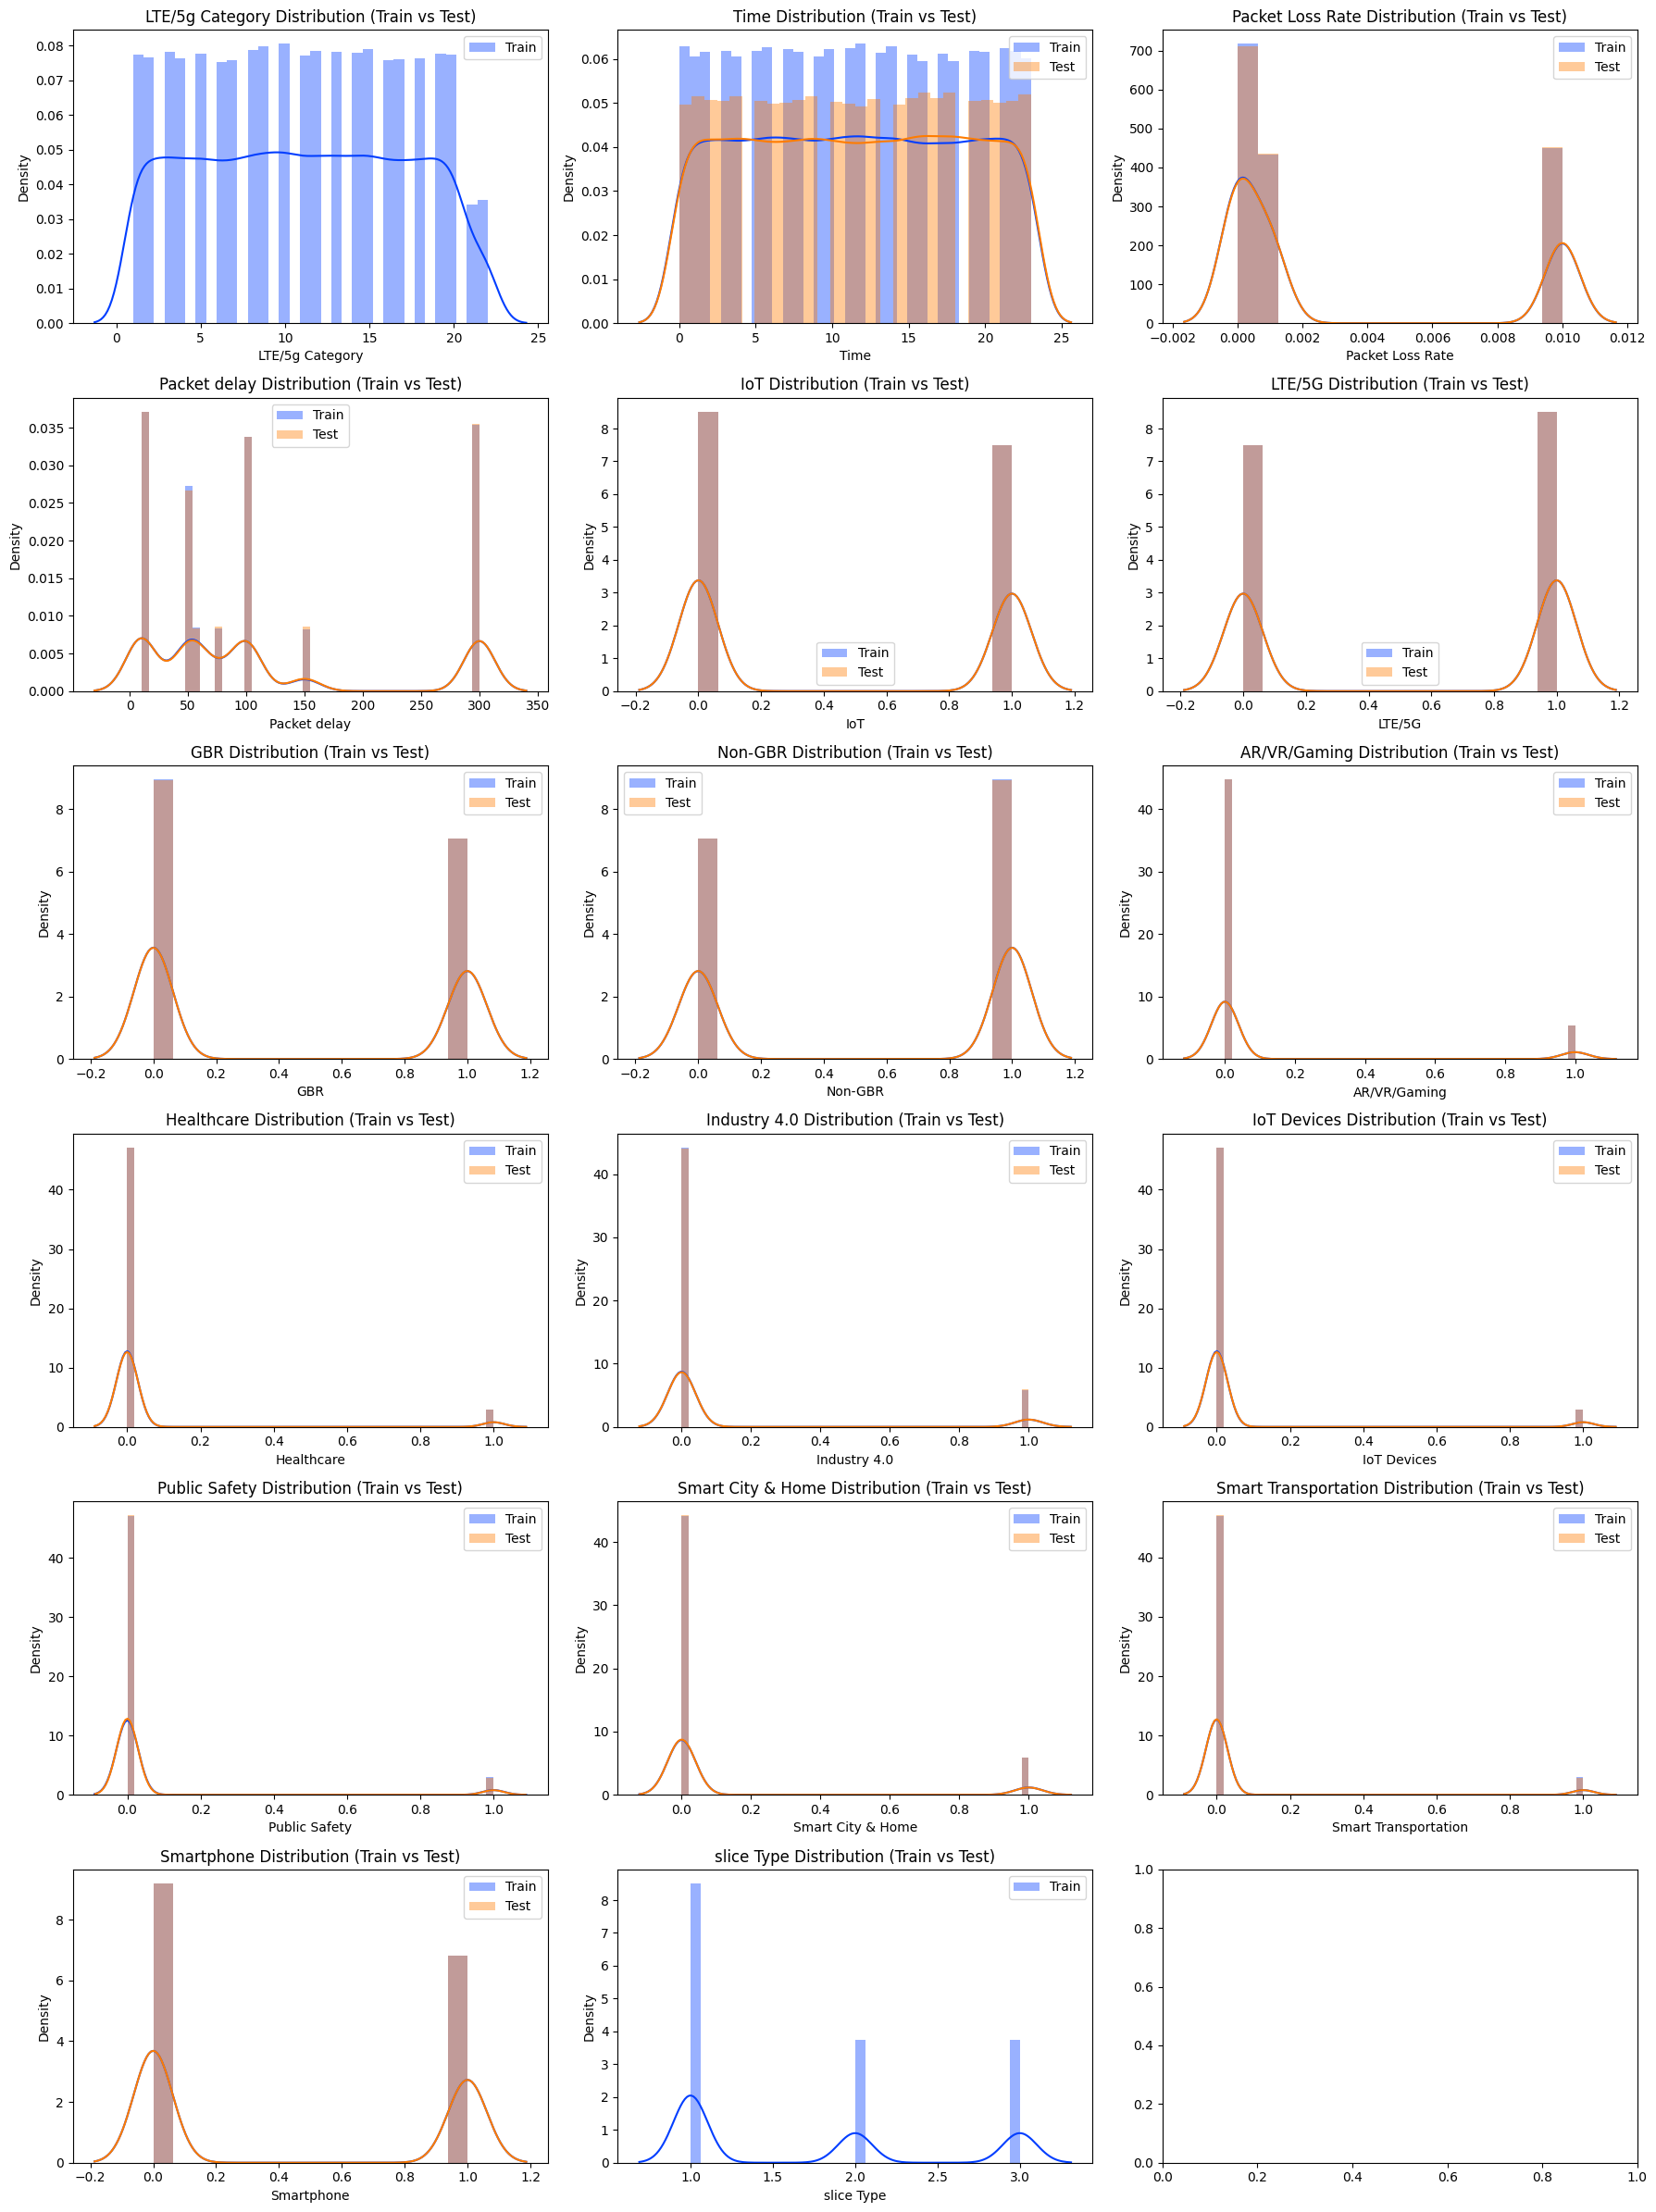

In [11]:
def plot_histograms(df_train, df_test, target, n_cols=3):
    n_rows = (len(df_train.columns) - 1) // n_cols + 1
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, 4*n_rows))
    axes = axes.flatten()

    for i, var_name in enumerate(df_train.columns.tolist()):
        ax = axes[i]
        sns.distplot(df_train[var_name], kde=True, ax=ax, label='Train')
        if var_name != target_1 and var_name != target_2:
            sns.distplot(df_test[var_name], kde=True, ax=ax, label='Test')
        ax.set_title(f'{var_name} Distribution (Train vs Test)')
        ax.legend()

    plt.tight_layout()
    plt.show()
        
plot_histograms(train, test, target_1, n_cols=3)

<p style="padding:15px; background-color:#000000; font-weight:bold; color:#362FD9; font-size:100%; border-radius: 15px 15px;">
    <b>💡 Additional Insights:<br><br>
+) From the above analysis, it can be seen that the dataset is imbalanced <br>
+) The train and the test datasets seem to have same characteristics <br> 
 

# <p style="padding:15px; background-color:#362FD9; font-family:JetBrains Mono; font-weight:bold; color:#000000; font-size:100%; letter-spacing: 2px; text-align:center; border-radius: 15px 15px; border: 5px solid #000000">2. Bivariate Stats</p> 

<p style="padding:15px; background-color:#000000; font-weight:bold; color:#362FD9; font-size:100%; border-radius: 15px 15px;">
    <b>💡 Recall: There are three types of bivariate analysis.</b><br>       
<ul> 
<li> <b>Numerical - Numerical: Pearson's Correlation</b> </li> <br>
The correlation represents the strength of a linear relationship between two numerical variables. If there is no correlation between the two variables, there is no tendency to change along with the values of the second quantity.  <br>  <br>
<li> <b>Categorical - Numerical: one-way ANOVA(3 + groups) or t-test (exactly 2 groups)</b>       </li> <br>
The ANOVA test is used to determine whether there is a significant difference among the averages of more than two groups that are statistically different from each other. <br><br>
<li> <b>Categorical - Categorical: Chi-square Test</b>       </li> <br>
It is calculated based on the difference between expected frequencies and the observed frequencies in one or more categories of the frequency table.
</ul>
</p> 

In [12]:
# this just an intermediate function that will be used in bivstats for one-way ANOVA
def anova(df, feature, label):
    import pandas as pd
    import numpy as np
    from scipy import stats
    
    groups = df[feature].unique()
    df_grouped = df.groupby(feature)
    group_labels = []
    for g in groups:
        g_list = df_grouped.get_group(g)
        group_labels.append(g_list[label])
        
    return stats.f_oneway(*group_labels)

# function to calculate bivariate stats; Pearson' correlation, p-value and one-way ANOVA
def bivstats(df, label):
    from scipy import stats
    import pandas as pd
    import numpy as np
    
    # Create an empty DataFrame to store output
    output_df = pd.DataFrame(columns=['Stat', '+1/-1 * ', 'Effect size', 'p-value'])
    
    for col in df:
        if col != label:
            if df[col].isnull().sum() == 0:
                if is_numeric_dtype(df[col]):   # Calculate r and p
                    r, p = stats.pearsonr(df[label], df[col])
                    output_df.loc[col] = ['r', np.sign(r), abs(round(r, 3)), round(p,6)]
                    
                else:
                    F, p = anova(df[[col, label]], col, label)
                    output_df.loc[col] = ['F', '', round(F, 3), round(p,6)]
                    
            else:
                output_df.loc[col] = [np.nan, np.nan, np.nan, np.nan]

    return output_df.sort_values(by=['Effect size', 'Stat'], ascending=[False, False])
 
pd.options.display.float_format = '{:.5f}'.format

In [13]:
bivstats(train, target_1)

,Stat,+1/-1 *,Effect size,p-value
IoT,r,1.00000,0.91000,0.00000
LTE/5G,r,-1.00000,0.91000,0.00000
Smartphone,r,-1.00000,0.73400,0.00000
Packet delay,r,-1.00000,0.39700,0.00000
Public Safety,r,1.00000,0.39700,0.00000
Smart Transportation,r,1.00000,0.39400,0.00000
Healthcare,r,1.00000,0.39100,0.00000
Industry 4.0,r,1.00000,0.35000,0.00000
GBR,r,-1.00000,0.33100,0.00000
Non-GBR,r,1.00000,0.33100,0.00000


In [14]:
bivstats(train, target_2)

,Stat,+1/-1 *,Effect size,p-value
IoT,r,1.00000,0.08700,0.00000
LTE/5G,r,-1.00000,0.08700,0.00000
slice Type,r,1.00000,0.07700,0.00000
Smartphone,r,-1.00000,0.07100,0.00000
Industry 4.0,r,1.00000,0.03900,0.00000
Smart City & Home,r,1.00000,0.03700,0.00000
AR/VR/Gaming,r,-1.00000,0.02700,0.00000
IoT Devices,r,1.00000,0.02500,0.00001
Healthcare,r,1.00000,0.02400,0.00002
Packet Loss Rate,r,1.00000,0.02000,0.00035


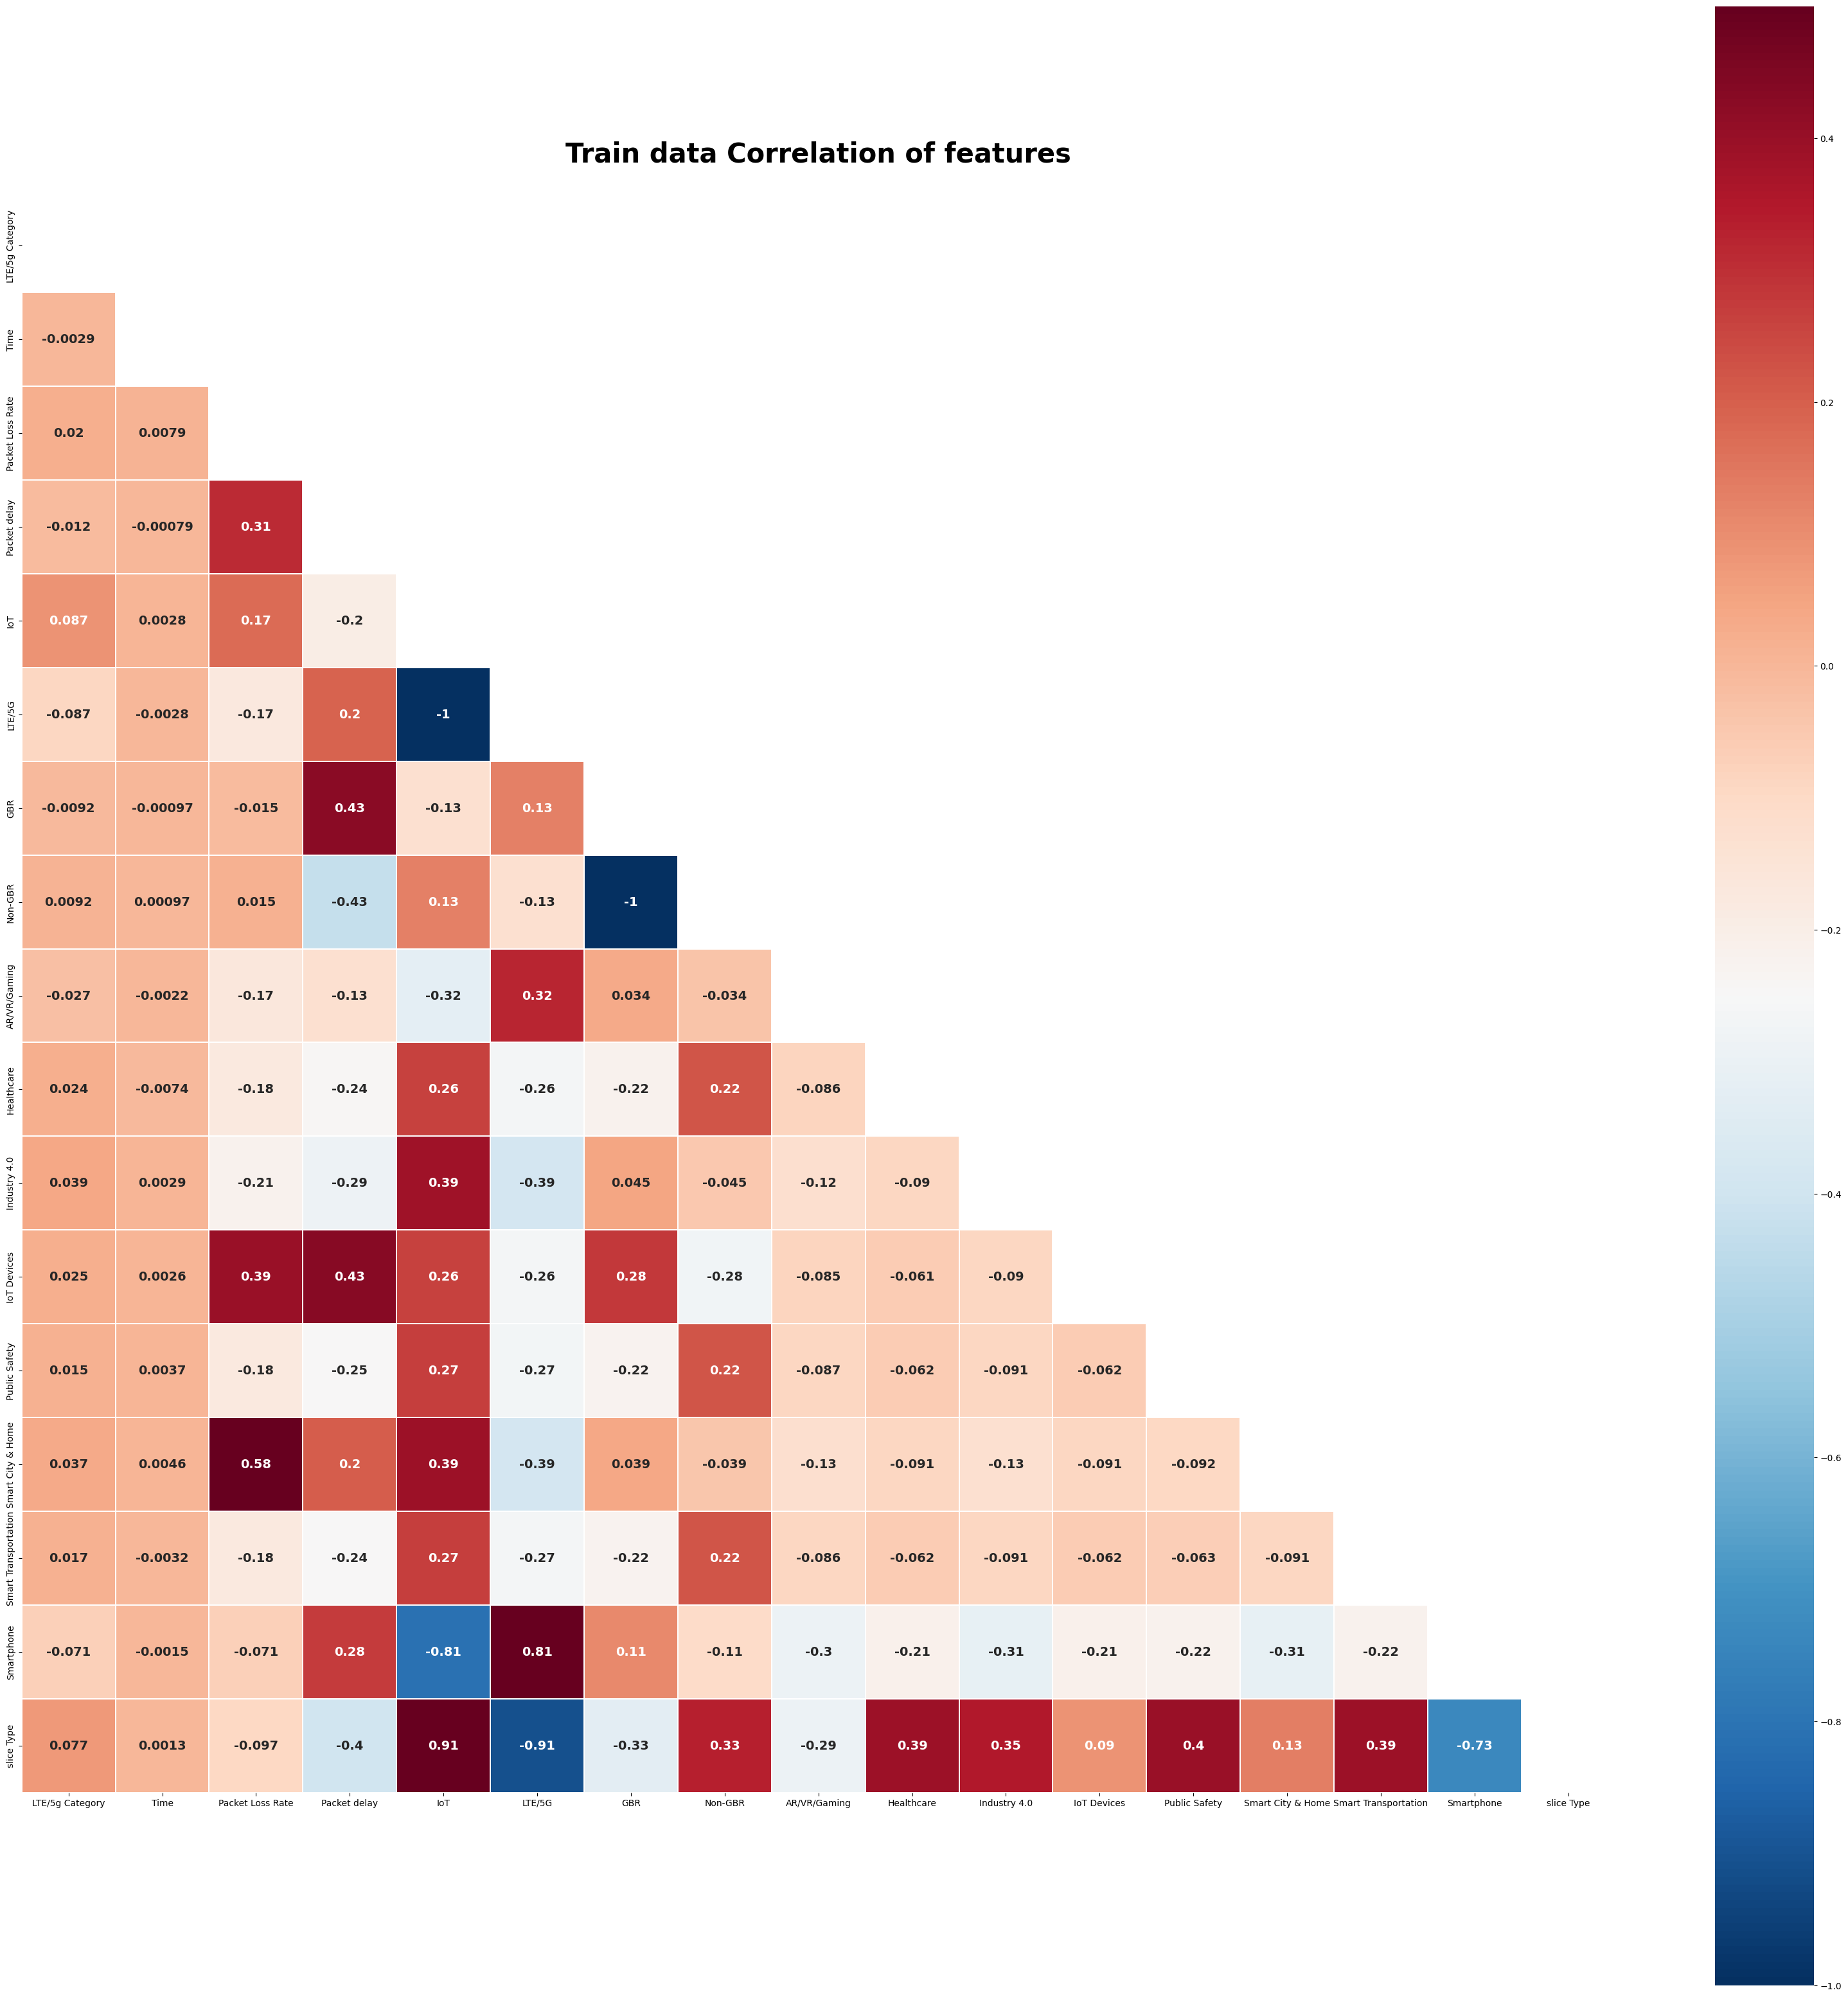

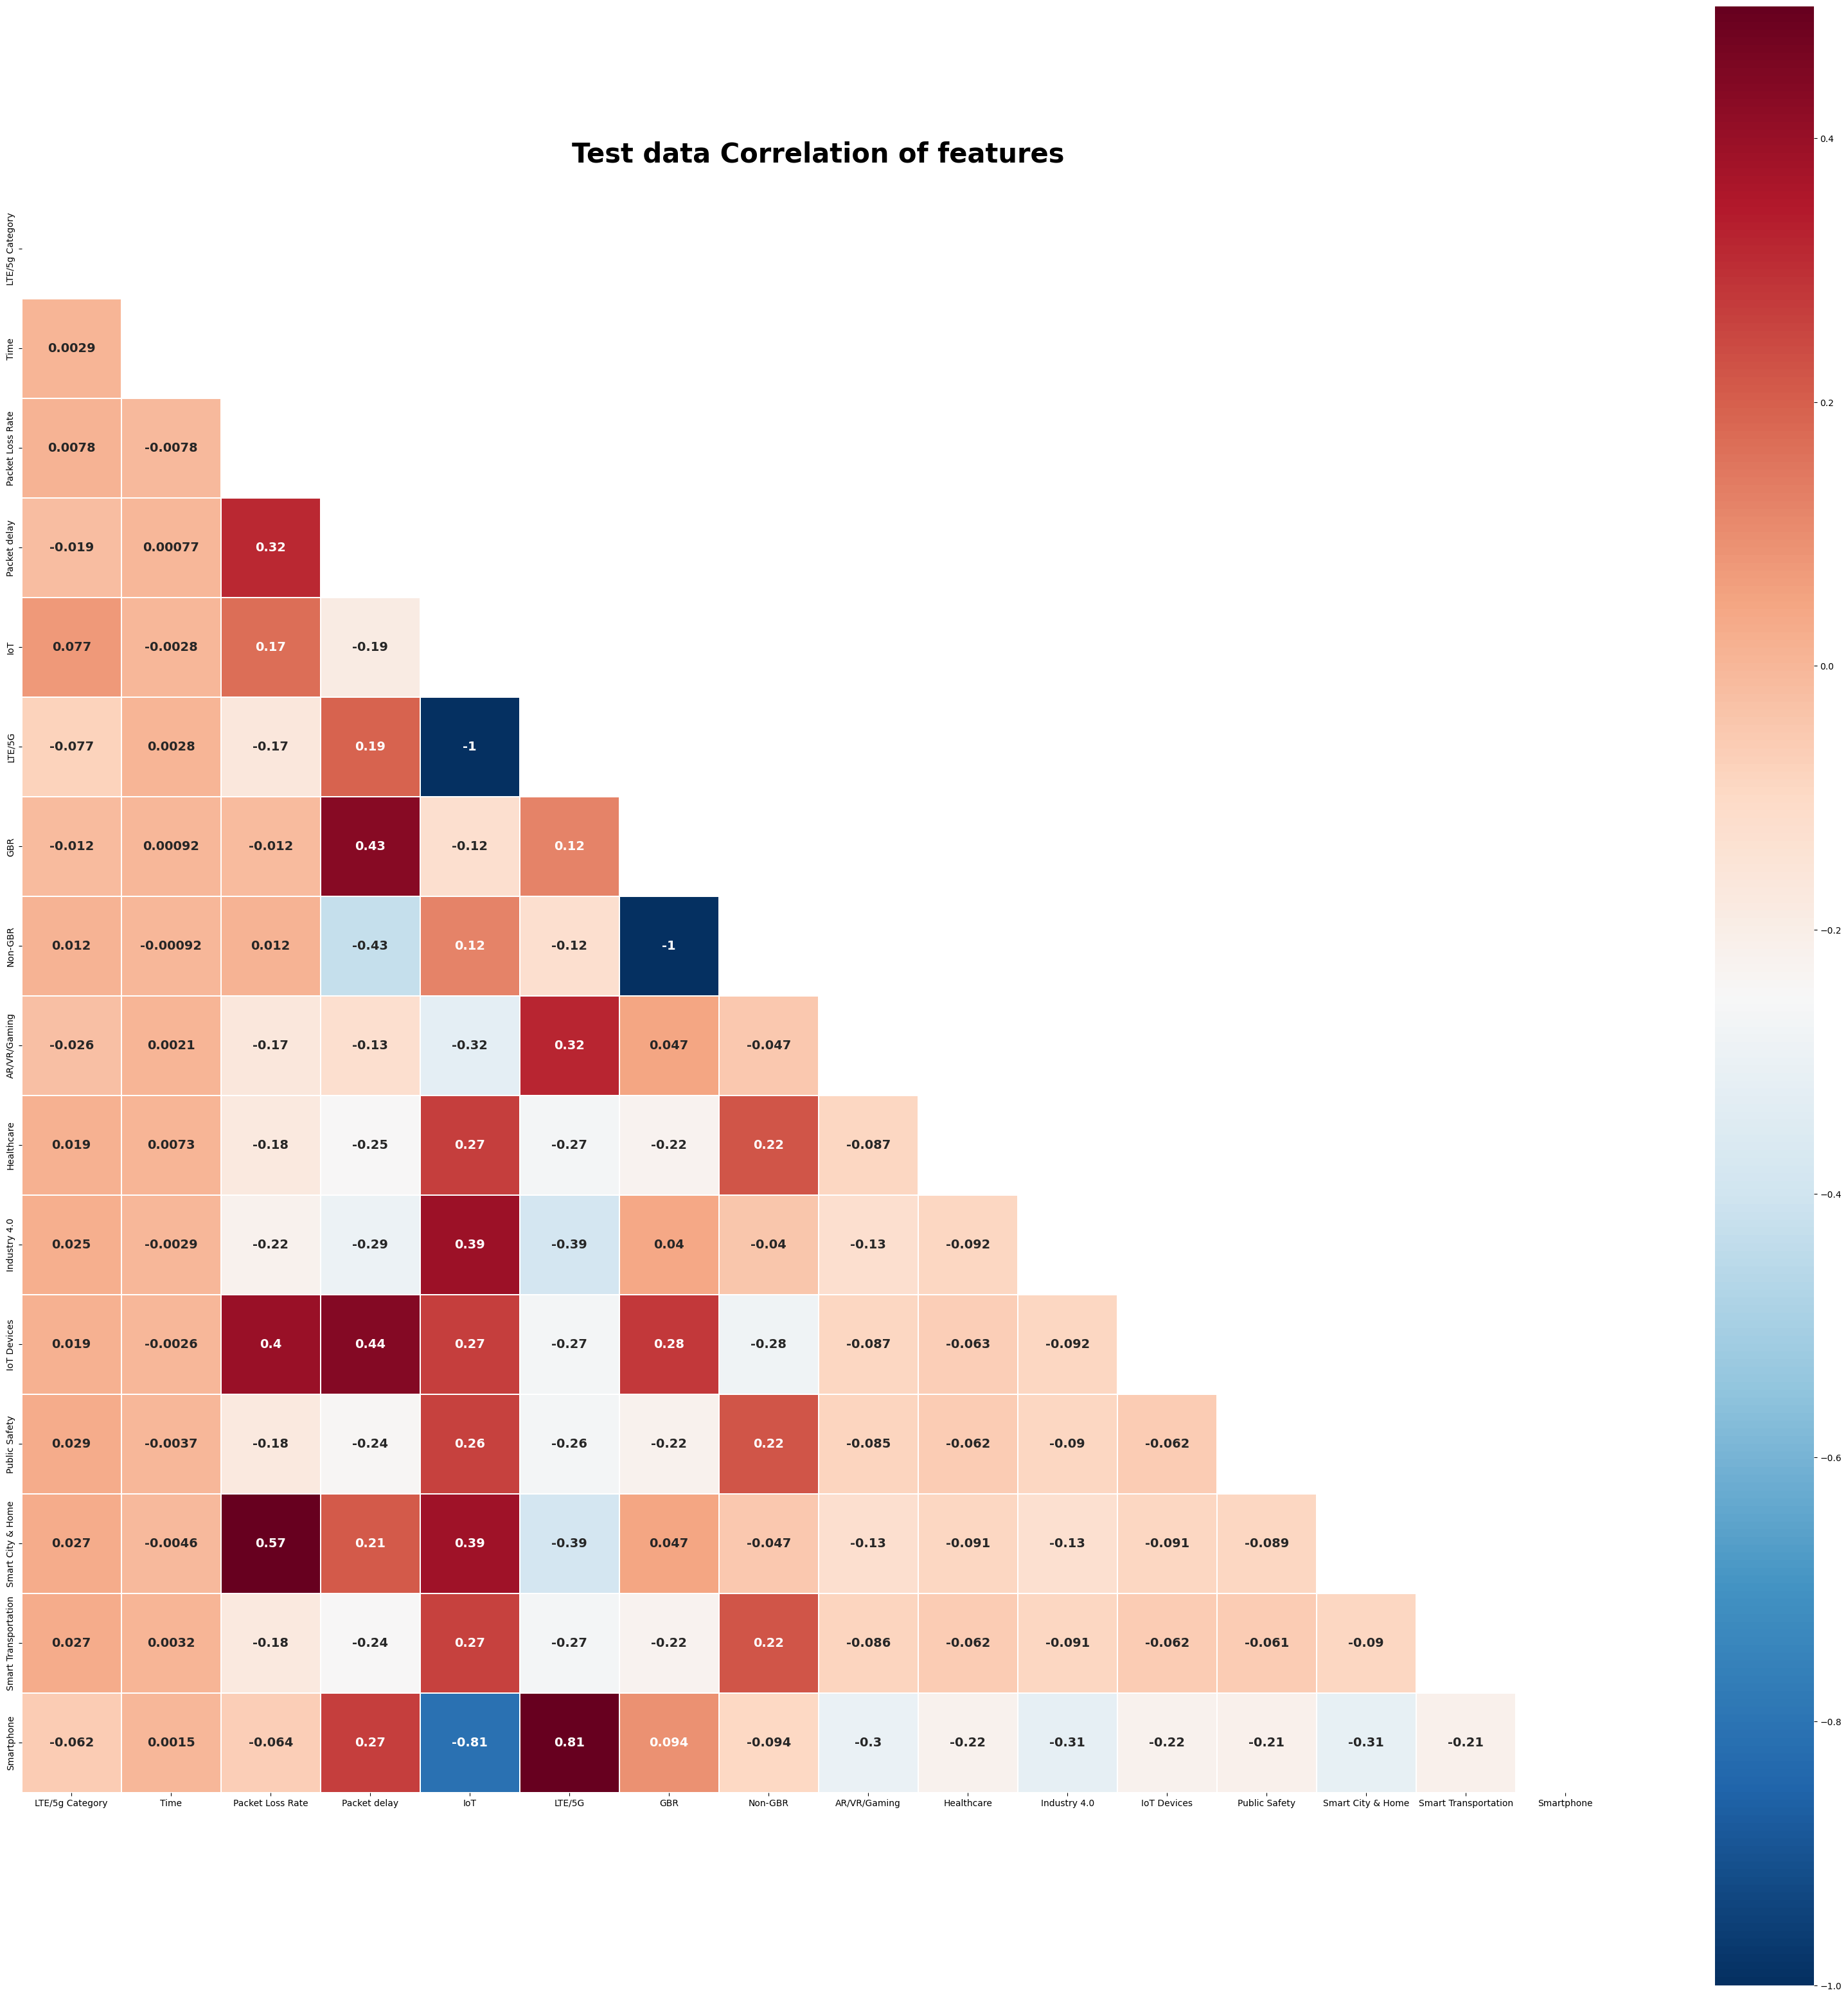

In [15]:
def plot_heatmap(df, title):
    # Create a mask for the diagonal elements
    mask = np.zeros_like(df.astype(float).corr())
    mask[np.triu_indices_from(mask)] = True

    # Set the colormap and figure size
    colormap = plt.cm.RdBu_r
    plt.figure(figsize=(40, 40))

    # Set the title and font properties
    plt.title(f'{title} Correlation of features', fontweight='bold', y=1.02, size=30)

    # Plot the heatmap with the masked diagonal elements
    sns.heatmap(df.astype(float).corr(), linewidths=0.1, vmax=0.5, vmin=-1.0, 
                square=True, cmap=colormap, linecolor='white', annot=True, annot_kws={"size": 14, "weight": "bold"},
                mask=mask)

plot_heatmap(train, title='Train data')
plot_heatmap(test, title='Test data')

<p style="padding:15px; background-color:#000000; font-weight:bold; color:#362FD9; font-size:100%; border-radius: 15px 15px;">
    <b>💡 Insights : <br>
        +) There is a strong correlation between certain columns of the dataset therefore I'll drop some of the columns which have high correlation between each other. <br>
        +) Applying PCA to reduce the number of features might be a good idea.
</b>
</p> 

In [16]:
train.columns

Index(['LTE/5g Category', 'Time', 'Packet Loss Rate', 'Packet delay', 'IoT',
       'LTE/5G', 'GBR', 'Non-GBR', 'AR/VR/Gaming', 'Healthcare',
       'Industry 4.0', 'IoT Devices', 'Public Safety', 'Smart City & Home',
       'Smart Transportation', 'Smartphone', 'slice Type'],
      dtype='object')

<p style="padding:15px; background-color:#000000; font-weight:bold; color:#362FD9; font-size:100%; border-radius: 15px 15px;">
    <b>💡 Encoding & Scaling: <br><br>
       

</b>
</p> 

In [17]:
import seaborn as sns

<Axes: xlabel='slice Type', ylabel='Healthcare'>

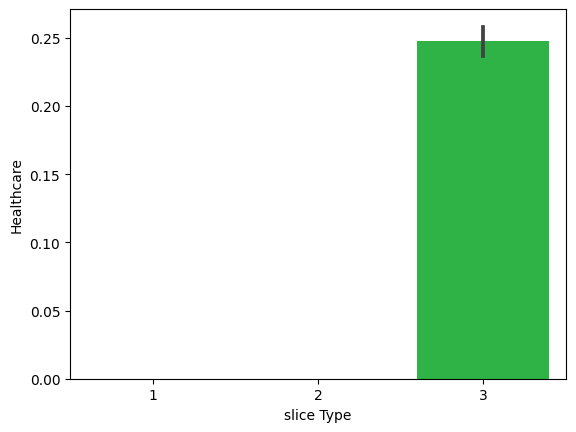

In [18]:
sns.barplot(x="slice Type",y="Healthcare",data=train)

<Axes: xlabel='slice Type', ylabel='Industry 4.0'>

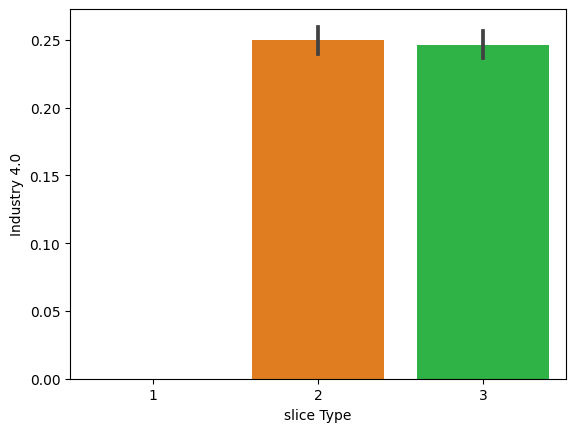

In [19]:
sns.barplot(x="slice Type",y="Industry 4.0",data=train)

<Axes: xlabel='slice Type', ylabel='IoT'>

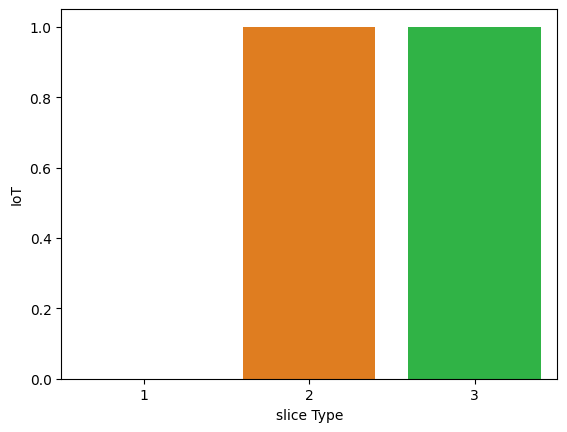

In [20]:
sns.barplot(x="slice Type",y="IoT",data=train)

<Axes: xlabel='slice Type', ylabel='AR/VR/Gaming'>

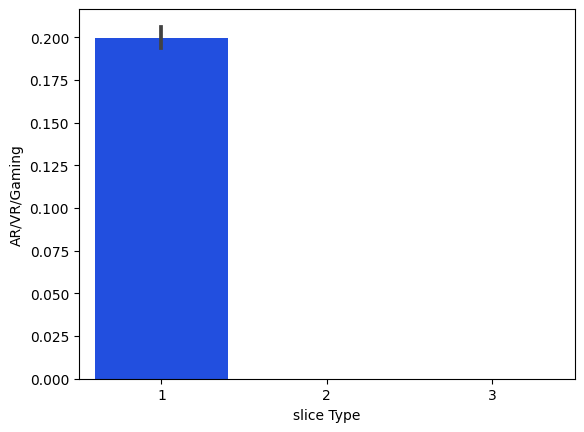

In [21]:
sns.barplot(x="slice Type",y="AR/VR/Gaming",data=train)

<Axes: xlabel='slice Type', ylabel='Smartphone'>

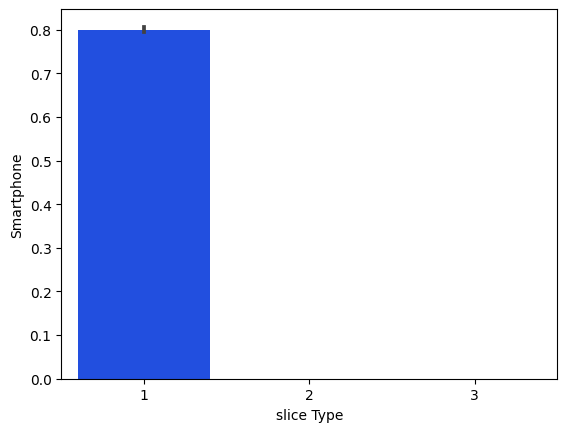

In [22]:
sns.barplot(x="slice Type",y="Smartphone",data=train)

<Axes: xlabel='slice Type', ylabel='IoT Devices'>

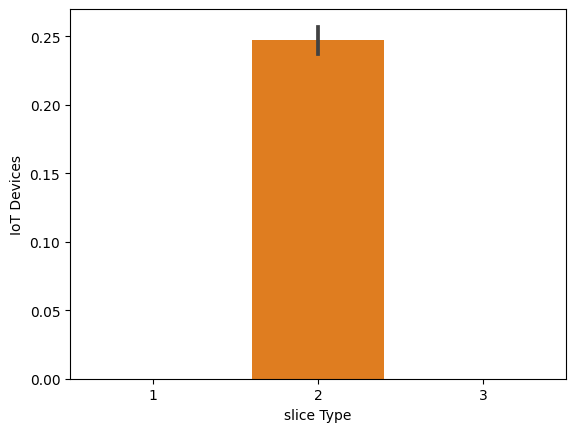

In [23]:
sns.barplot(x="slice Type",y="IoT Devices",data=train)

<Axes: xlabel='slice Type', ylabel='Public Safety'>

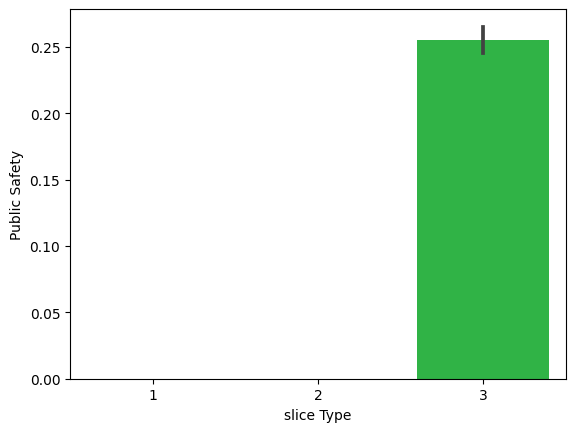

In [24]:
sns.barplot(x="slice Type",y="Public Safety",data=train)

<Axes: xlabel='slice Type', ylabel='Smart Transportation'>

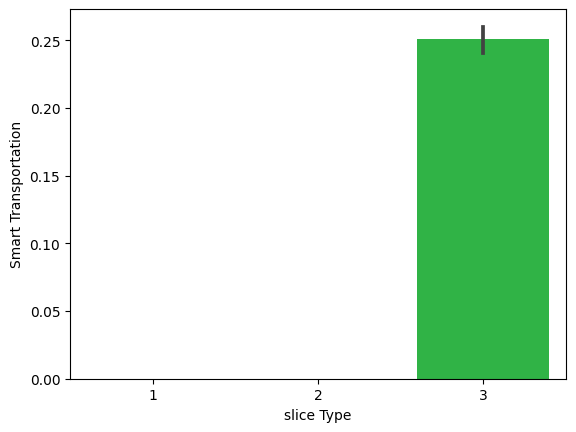

In [25]:
sns.barplot(x="slice Type",y="Smart Transportation",data=train)

In [26]:
train['slice Type'].sum()

53759

In [27]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31583 entries, 0 to 31582
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   LTE/5g Category       31583 non-null  int64  
 1   Time                  31583 non-null  int64  
 2   Packet Loss Rate      31583 non-null  float64
 3   Packet delay          31583 non-null  int64  
 4   IoT                   31583 non-null  int64  
 5   LTE/5G                31583 non-null  int64  
 6   GBR                   31583 non-null  int64  
 7   Non-GBR               31583 non-null  int64  
 8   AR/VR/Gaming          31583 non-null  int64  
 9   Healthcare            31583 non-null  int64  
 10  Industry 4.0          31583 non-null  int64  
 11  IoT Devices           31583 non-null  int64  
 12  Public Safety         31583 non-null  int64  
 13  Smart City & Home     31583 non-null  int64  
 14  Smart Transportation  31583 non-null  int64  
 15  Smartphone         

In [28]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31584 entries, 0 to 31583
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   LTE/5g Category       31584 non-null  int64  
 1   Time                  31584 non-null  int64  
 2   Packet Loss Rate      31584 non-null  float64
 3   Packet delay          31584 non-null  int64  
 4   IoT                   31584 non-null  int64  
 5   LTE/5G                31584 non-null  int64  
 6   GBR                   31584 non-null  int64  
 7   Non-GBR               31584 non-null  int64  
 8   AR/VR/Gaming          31584 non-null  int64  
 9   Healthcare            31584 non-null  int64  
 10  Industry 4.0          31584 non-null  int64  
 11  IoT Devices           31584 non-null  int64  
 12  Public Safety         31584 non-null  int64  
 13  Smart City & Home     31584 non-null  int64  
 14  Smart Transportation  31584 non-null  int64  
 15  Smartphone         

In [29]:
y  = train['slice Type']
X  = train.drop(columns=['slice Type'], axis=1)

In [30]:
y.head()

0    3
1    1
2    1
3    1
4    2
Name: slice Type, dtype: int64

In [31]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.20, random_state =42)

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load the data
#X_train, X_test, y_train, y_test = load_data()

# Train the model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Generate classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Generate confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 1.0

Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      3316
           2       1.00      1.00      1.00      1482
           3       1.00      1.00      1.00      1519

    accuracy                           1.00      6317
   macro avg       1.00      1.00      1.00      6317
weighted avg       1.00      1.00      1.00      6317


Confusion Matrix:
[[3316    0    0]
 [   0 1482    0]
 [   0    0 1519]]


# <p style="padding:15px; background-color:#362FD9; font-family:JetBrains Mono; font-weight:bold; color:#000000; font-size:100%; letter-spacing: 2px; text-align:center; border-radius: 15px 15px; border: 5px solid #000000">IV.  Model building</p>

# **1. Basic Approach**

In [39]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score

import pickle 

In [41]:
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

In [52]:
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(max_iter=1000, tol=1e-3)

# Without Scaling
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
#print("Without Scaling and CV: ",accuracy_score(y_test,y_pred))
scores = cross_val_score(clf, X_train, y_train, cv=10)
print("Without Scaling and With CV: ",scores.mean())

# With Scaling 
clf.fit(X_train_scale,y_train) 
y_pred = clf.predict(X_test_scale)
#print("With Scaling and Without CV: ",accuracy_score(y_test,y_pred))
scores = cross_val_score(clf, X_train_scale, y_train, cv=10)
#print("With Scaling and With CV: ",scores.mean())

Without Scaling and With CV:  0.9531062153445873


In [45]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0)

#without scaling
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Without Scaling and CV: ",accuracy_score(y_test,y_pred))
scores = cross_val_score(clf, X_train, y_train, cv=10)
print("Without Scaling and With CV: ",scores.mean())

# With Scaling 
clf.fit(X_train_scale,y_train) 
y_pred = clf.predict(X_test_scale)
print("With Scaling and Without CV: ",accuracy_score(y_test,y_pred))
scores = cross_val_score(clf, X_train_scale, y_train, cv=10)
print("With Scaling and With CV: ",scores.mean())

Without Scaling and CV:  1.0
Without Scaling and With CV:  1.0
With Scaling and Without CV:  1.0
With Scaling and With CV:  1.0
